In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

In [2]:
apps = pd.read_csv('apps_rev.csv')
apps.drop('Unnamed: 0', inplace = True, axis = 1)

In [3]:
reviews = pd.read_csv('with_avg.csv')
reviews.drop('Unnamed: 0', inplace = True, axis = 1)

In [4]:
calced = pd.read_csv('calced.csv')
calced.drop('Unnamed: 0', inplace = True, axis = 1)

# Inferential Statistics

My goal in this section is to discover whether or not some of the disparities in the data, such as the difference in means or medians in some of the categories is truly a statistically significant difference. 

I may try a few OLS regressions to see if there is any way to predict the number of installs or the revenue based on the category of the app. Because of the amount of apps in the data nad wide range of installs and revenue in each category, this may be impossible, but I would be able to use this to help my client decide which app to make. 

In [5]:
(len(apps.loc[apps['Type'] == 'Paid'])/len(apps))*100

7.335201657121969

In my exploratory data analysis, I found that there was a disproportionate amount of free apps compared to paid apps. We found that only 7.33% of apps were paid. Just to make sure, I will run a hypothesis test to find out if that is true for the population, and not just this sample. My hypotheses will be as follows:

$H_0$: $p_{paid} = 0.07$ 

$H_a$: $p_{paid} \neq 0.07$, where p is the proportion of paid to free apps

with a level of $\alpha = 0.05$



In [6]:
stat, pval = proportions_ztest(len(apps.loc[apps['Type'] == 'Paid']), len(apps), 0.07)
stat, pval

(1.1647559892012007, 0.24411777833098114)

We got a z-stat of 1.164 and a p-value of 0.244. This means that we cannot statistically claim that the proportion of apps paid for is 7%. We can check if the proportion of free apps is greater than the paid apps though in another test. Since there are only 2 options, free or paid, we can run the same test but change the porportion to 50%. 

$H_0$: $p_{paid} = 0.5$ 

$H_a$: $p_{paid} < 0.5$, where p is the proportion of paid apps 

with a level of $\alpha = 0.05$

In [7]:
stat, pval = proportions_ztest(len(apps.loc[apps['Type'] == 'Paid']), len(apps), 0.50)
stat, pval*2

(-148.2512939363146, 0.0)

The z-stat is very large, and the pvalue is pretty much zero, so we can state that the proportion of paid apps is less than 50%, and therefore there is a larger proportion of free apps than there are paid apps. 

### Are medical apps installed at a statistically higher rate than the rest of the apps?

In [12]:
prop_medical = (np.sum(apps.loc[apps['Category'] == 'Medical'].loc[apps['Type'] == 'Paid']['Installs'])\
                /np.sum(apps.loc[apps['Category'] == 'Medical']['Installs']))*100
prop_rest = (np.sum(apps.loc[apps['Category'] != 'Medical'].loc[apps['Type'] == 'Paid']['Installs'])\
                /np.sum(apps.loc[apps['Category'] != 'Medical']['Installs']))*100

In [13]:
prop_medical, prop_rest

(1.4199235935930603, 0.07532621880198209)

Around 1.4% of all Medicall app installs are paid for, while only about 0.07$ of all other apps are paid for. The hypotheses for this test are:

$H_0: p_{medical} \leq p_{non-medical}$

$H_a: p_{medical} > p_{non-medical}$, where $p$ is the proportion of installs that are paid for

at a level $\alpha = 0.05$


In [14]:
pooled = ((prop_medical * len(apps.loc[apps['Category'] == 'Medical']['Installs'])) + \
        (prop_rest * len(apps.loc[apps['Category'] != 'Medical']['Installs'])))/len(apps)
pooled

0.12332999981986754

In [15]:
SE = np.sqrt(pooled*( 1 - pooled )*((1/len(apps.loc[apps['Category'] == 'Medical']['Installs']))\
                                    + (1/len(apps.loc[apps['Category'] != 'Medical']['Installs']))))
SE

0.01956198049700197

In [16]:
z = (prop_medical - prop_rest)/SE
z

68.73523746724666

In [17]:
p_value = stats.norm.sf(abs(z))
p_value

0.0

The p-value is pretty much 0, so we can rule out the null hypothesis that paid apps for the medical category  and other categories are installed at the same rate, and that **medical paid apps are installed higher than the rest**. 

# Do Family apps have a higher average revenue than other apps?

In order to do test this one, I am going to use a one-tailed hypothesis test for a difference in means. First I am going to do a bootstrapping test, and then I am going to use the t test module in scipy.stats. My hypotheses are as follows:

H_0: $\mu_{Family} \leq \mu_{not-family}$

H_a: $\mu_{family} > \mu_{not-communication}$ Where $\mu$ is the mean revenue of all apps in that category or categories.

At an $\alpha = 0.05$ level. 

This is after removing the expensive apps in the lifestyle and finance categories

In [18]:
emp_mean_diff = np.mean(apps.loc[apps['Category'] == 'Entertainment']['Revenue'])-\
                np.mean(apps.loc[apps['Category'] != 'Entertainment'].loc[apps['Price'] < 200]['Revenue'])
emp_mean_diff

45141.45966178777

The empirical difference between apps in the family category and apps not in that category is aroun $55,272. 

In [19]:
def permutations(data_1, data_2):
    """This is a function for drawing random drawing without replacement from 2 distributions as if they were 1"""
    data = np.concatenate((data_1, data_2))
    perms = np.random.choice(data, len(data))
    perm_cat1 = perms[:len(data_1)]
    perm_cat2 = perms[len(data_1):]
    return perm_cat1, perm_cat2

In [20]:
def bootstrap(data_1, data_2, size):
    """This is a function written to take the mean of the permutations drawn in the above function"""
    boots = np.empty(size)
    for i in range(size):
        perm_cat1, perm_cat2 = permutations(data_1, data_2)
        boots[i] = np.mean(perm_cat1) - np.mean(perm_cat2)
    return boots

In [21]:
theo_mean_diffs = bootstrap(apps.loc[apps['Category'] == 'Entertainment']['Revenue'],\
                            apps.loc[apps['Category'] != 'Entertainment'].loc[apps['Price']<200]['Revenue'],10000)

In [22]:
p = np.sum(theo_mean_diffs >= emp_mean_diff)/ float((len(theo_mean_diffs)))
p*2

0.0468

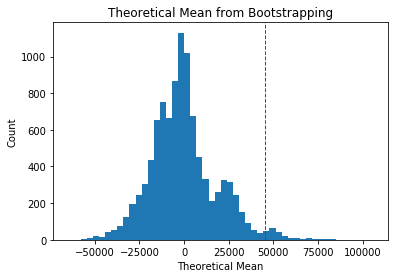

In [23]:
#Interesting. There seems to be multiple peaks in the distribution
_ = plt.hist(theo_mean_diffs,bins = 50)
_ = plt.axvline(emp_mean_diff, color='r', linestyle='dashed', linewidth=1)
_ = plt.title('Theoretical Mean from Bootstrapping')
_ = plt.ylabel('Count')
_ = plt.xlabel('Theoretical Mean')

In [24]:
t_fam_rest = stats.ttest_ind(apps.loc[apps['Category']=='Entertainment']['Revenue']\
                                   , apps.loc[apps['Category'] != 'Entertainment'].loc[apps['Price'] < 200]['Revenue'])
t_fam_rest.pvalue *2 

0.03217538411345393

I get slightly different answers from both tests, but both scores allow me to reject the null hypothesis that the mean revenue from apps in the family category is less than or equal to the mean revenue from apps in all other categories.  

# Do Communication Apps have the highest install rate?

In order to do test this one, I am going to use a one-tailed hypothesis test for a difference in means. First I am going to do a bootstrapping test, and then I am going to use the t test module in scipy.stats. My hypotheses are as follows:

H_0: $\mu_{Communication} \leq \mu_{not-communication}$

H_a: $\mu_{communication} > \mu_{not-communication}$ Where $\mu$ is the mean number of installs of all apps in that category or categories.

At an $\alpha = 0.05$ level. 



In [25]:
emp_mean_diff2 = np.mean(apps.loc[apps['Category'] == 'Social']['Installs'])-\
                np.mean(apps.loc[apps['Category'] != 'Social']['Installs'])
emp_mean_diff2

28333006.13605126

In [26]:
theo_mean_diffs2 = bootstrap(apps.loc[apps['Category'] == 'Social']['Installs'],\
                            apps.loc[apps['Category'] != 'Social']['Installs'],10000)

In [27]:
p2 = np.sum(theo_mean_diffs2 >= emp_mean_diff2)/ float((len(theo_mean_diffs2)))
p2*2

0.0

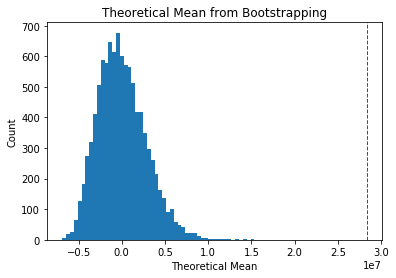

In [28]:
#Interesting. There seems to be multiple peaks in the distribution
_ = plt.hist(theo_mean_diffs2,bins = 50)
_ = plt.axvline(emp_mean_diff2, color='r', linestyle='dashed', linewidth=1)
_ = plt.title('Theoretical Mean from Bootstrapping')
_ = plt.ylabel('Count')
_ = plt.xlabel('Theoretical Mean')

In [30]:
t_com_rest = stats.ttest_ind(apps.loc[apps['Category']=='Social']['Installs']\
                                   , apps.loc[apps['Category'] != 'Social']['Installs'])
t_com_rest.pvalue *2 

5.3334088082367525e-24

Pretty much none of the boostrapped mean differences are as extreme as the difference in the data. I also got a very small number from the t-test at the order of $10^{-21}$. This means that I can reject the null-hypothesis that communication apps are have a smaller or equal install rate than the rest of the categories.

# Of categories with more than 10 paid apps, do Health and Fitness apps have the highest median number of installs?

For this test, I am going to use these hypotheses for a one-tailed test:

H_0: $M_{Health-and-fitness} \leq M_{not-health-and-fitness}$

H_a: $M_{Health-and-fitness} > M_{not-health-and-fitness}$ Where $M$ is the median number of installs of paid apps in that category or categories.

At an $\alpha = 0.05$ level. 

In [31]:
cat_10 = [x for x in apps['Category'].unique() if len(apps.loc[apps['Category'] == x].loc[apps['Type'] == 'Paid']['Installs']) > 10]
cat_10


['Hobbies',
 'Travel',
 'Lifestyle',
 'Business',
 'Social',
 'Entertainment',
 'Medical',
 'Productivity']

In [32]:
stat, p = stats.kruskal(apps.loc[apps['Category'] == 'Lifestyle'].loc[apps['Type'] == 'Paid']['Installs'],\
             apps.loc[apps['Category'].isin(cat_10)].loc[apps['Type'] == 'Paid']['Installs'])

In [33]:
p*2 #Because its a one sided test, multiply the p-value by 2

0.8542583002812898

This does not pass the test. We cannot reject the null hypothesis that paid Health and Fitness Apps garner the most installations. 

Here, I perform the same test, except with the mean, and testing to see if the mean installs of paid apps is significantly greater for gaming apps than the rest. 

In [34]:
emp_mean_diff3 = np.mean(apps.loc[apps['Category'] == 'Entertainment'].loc[apps['Type'] == 'Paid']['Installs'])-\
                np.mean(apps.loc[apps['Category'].isin(cat_10)].loc[apps['Type'] == 'Paid']['Installs'])
emp_mean_diff3

80992.66304014038

In [35]:
theo_mean_diffs3 = bootstrap(apps.loc[apps['Category'] == 'Entertainment'].loc[apps['Type'] == 'Paid']['Installs'],\
                            apps.loc[apps['Category'].isin(cat_10)].loc[apps['Type'] == 'Paid']['Installs'],10000)

In [36]:
p3 = np.sum(theo_mean_diffs3 >= emp_mean_diff3)/ float((len(theo_mean_diffs3)))
p3*2

0.169

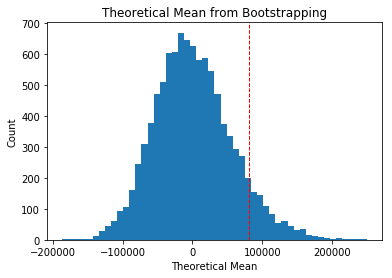

In [37]:
#Interesting. There seems to be multiple peaks in the distribution
_ = plt.hist(theo_mean_diffs3,bins = 50)
_ = plt.axvline(emp_mean_diff3, color='r', linestyle='dashed', linewidth=1)
_ = plt.title('Theoretical Mean from Bootstrapping')
_ = plt.ylabel('Count')
_ = plt.xlabel('Theoretical Mean')

In [39]:
t_game_rest = stats.ttest_ind(apps.loc[apps['Category'] == 'Entertainment'].loc[apps['Type'] == 'Paid']['Installs']\
                                   , apps.loc[apps['Category'].isin(cat_10)].loc[apps['Type'] == 'Paid']['Installs'])
t_game_rest.pvalue *2 

0.29447445184767856

I found out that games do not, at an $\alpha = 0.05$ level, have a higher rate of installs for paid apps than other categories. The alpha level is pretty low though, at 0.09 to 0.10. So though I cannot rule it out, there is still a possibility. 

## Checking to see if the correlation between avg_rating and number of installs is actually present. 

$H_0: R^2 \leq 0$

$H_a R^2 > 0$ where $R^2$ is the squared pearson correlation coefficient between number of installs and the average rating of an app.

At an $\alpha = 0.05$ 

In [40]:
corr = np.corrcoef(reviews['Installs'], reviews['avg_rating'])[0,1]**2
corr

0.0030384559455486275

In [41]:
def check_corr(df, col1, col2, corr):
    perm_data = np.empty(10000)

    """The purpose of this function is to shuffle the pairs without replacement and see how if the correlation between Installs and 
    average rating of the apps is statistically significant. Returns array of correlations and p-value"""
    for i in range(10000):
    
        shuffled = df[[col1,col2]].sample(frac = 1)
    
        permuted = np.random.choice(list(shuffled[col1]), len(shuffled[col1]), replace = False)
        shuffled_frame = pd.DataFrame({col1:permuted, col2: list(shuffled[col2].values)})
    
        perm_data[i] = (np.corrcoef(shuffled_frame[col1], shuffled_frame[col2])[0,1]**2)
        
        p = np.sum(perm_data >= corr)/ float(len(perm_data))

    return perm_data, p

In [42]:
perm_corr, p = check_corr(reviews, 'Installs','avg_rating', corr)

In [43]:
p*2

0.2252

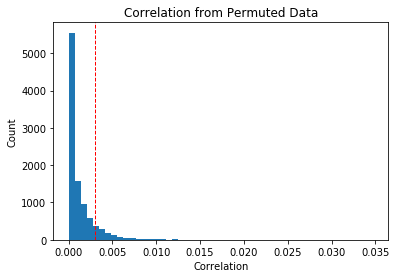

In [44]:
_ = plt.hist(perm_corr,bins = 50)
_ = plt.axvline(corr, color='r', linestyle='dashed', linewidth=1)
_ = plt.title('Correlation from Permuted Data')
_ = plt.ylabel('Count')
_ = plt.xlabel('Correlation')

As you can see, the correlation of 0.003 is well within the boundary of what can happen from a completely random distribution. The p-value is also $>>$ than the $\alpha$ confidence level of 0.05. We cannot dismiss the null hypothesis that the correlation between the average rating and number of installs is 0. 

In [45]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8207 entries, 0 to 8206
Data columns (total 14 columns):
App               8207 non-null object
Rating            8207 non-null float64
Reviews           8207 non-null int64
Size              8207 non-null float64
Installs          8207 non-null int64
Type              8207 non-null object
Price             8207 non-null float64
Content Rating    8207 non-null object
Genres            8207 non-null object
Last Updated      8207 non-null object
Current Ver       8207 non-null object
Android Ver       8207 non-null object
Category          8207 non-null object
Revenue           8207 non-null float64
dtypes: float64(4), int64(2), object(8)
memory usage: 897.7+ KB


In [46]:
dummies = pd.get_dummies(apps, columns = ['Category','Content Rating','Type'])

In [47]:
dummies.shape

(8207, 30)

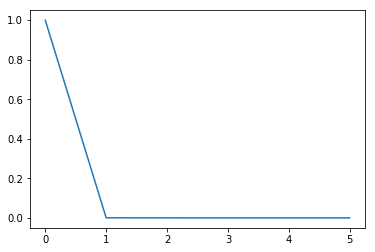

In [48]:
#Checking principal Component analysis
from sklearn.decomposition import PCA
pca = PCA()
model = pca.fit(apps.drop(['App','Content Rating','Type','Category','Genres','Last Updated','Current Ver','Android Ver'],axis = 1))
_ = plt.plot(range(len(model.explained_variance_)), model.explained_variance_ratio_)


In [49]:
model.explained_variance_ratio_

array([9.99028676e-01, 7.08038201e-04, 2.63286102e-04, 1.15518833e-13,
       7.74926996e-14, 8.43823259e-17])